#VisualBackProp

###Print current used tensorflow lib version


In [1]:
import tensorflow as tf
print(tf.__version__)

2.8.0


#Using VGG16 for XAI

In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions

model = VGG16()

553476096/553467096 [==============================] - 21s 0us/step


## High level algorithm

The method utilizes the forward propagation pass, which is already done to obtain a prediction,

1.   We will use the feature maps obtained after each ReLU layer, the feature maps from each layer are averaged
2.   The averaged feature map of the deepest convolutional
layer is scaled up to the size of the feature map of the previous layer using deconvolution
3.   Multiply with previous averaged map 
4.   Continue till the input layer


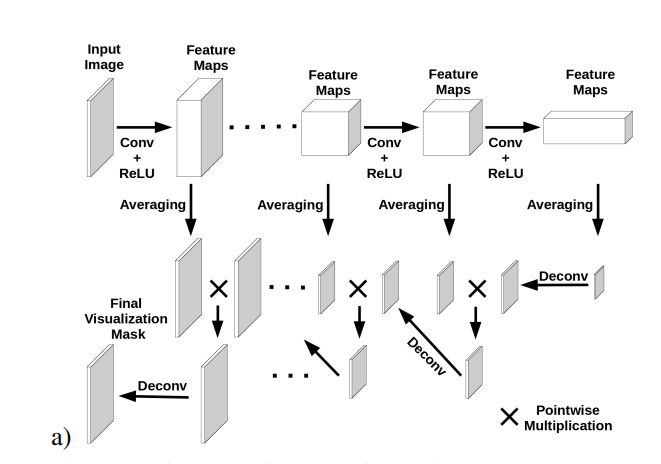

#Implementation of the vanilla method

In [3]:
class VisualBackProp():

    def __init__(self, model):
        '''
        model:keras.engine.functional.Functional -> model for inference 
        '''
        self.model = model

        #layers whose ouput needs to be averaged and perform inverse opperation
        self.layers = [ layer for layer in model.layers if 'conv' in layer.name or 'pool' in layer.name] 

        #averaged maps in the forward direction
        self.averaged_maps = []

        #image used to propogate in forward direction
        self.image = []

    def get_avg_image(self, feature_maps):
        '''
        Average feature maps of convolutional or pooling layers along the depth
        Dimenssions : (Batch, Width, Hight, Depth)
        Args:
            feature_maps : feature maps to be averaged
        Returns:
            Tensor of Class probality for each class
        '''
        return tf.reduce_mean(feature_maps, axis=-1)

    def run(self, image):
        '''
        Run Xai model on an Image
        Dimenssions : (Batch, Width, Hight, Channels)

        Args:
            image : numpy array
        Returns:
            image : Numpy array after performing VisualBackProp
        '''
        result = self.forward(image)
        return self.backword()

    @staticmethod
    def rescale(x):
        """
        Rescales relevance scores of a batch of relevance maps between 0 and 1
        Args:
            x: RGB or grayscale relevance maps with dimensions (N, W, H, C) or (N, W, H), respectively.
        Returns:
            Rescaled relevance maps of same dimensions as input
        """
        x_min = np.min(x, axis=(0, 1), keepdims=True)
        x_max = np.max(x, axis=(0, 1), keepdims=True)
        #tf.cast(x, tf.float32)
        return (x - x_min) / (x_max - x_min)

    def forward(self, image):
        '''
        Forward pass on image input, we also avgerage the feature maps and store them
        Args:
            Image :  image of dimension (Batch, Width, Hight, Channels)
        Returns:
            Tensor of Class probality for each class
        '''
        self.image = image
        self.averaged_maps = []
        image = preprocess_input(image)
        for layer in self.model.layers:

            image = layer(image)

            if layer in self.layers:
                self.averaged_maps.append(self.get_avg_image(image[0]))

        return image

    def backword(self):
        '''
        1.   We will use the feature maps obtained averaged during forward pass perform deconvolutional
        or unpooling.
        2.  We will use pixel wise multiplication to the scaled or deconvoluted maps with preceding averaged maps
        3.  We will continue till the input layer
        
        Returns:
            image : Numpy array for the VisualBackProp model
        '''
        reverse = self.averaged_maps[::-1]

        for image in range(len(reverse)-1):
            if reverse[image].shape != reverse[image+1].shape:
                input_x =  tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(np.expand_dims(reverse[image], axis=[0, -1]))
                input_x = self.rescale(input_x)
                reverse[image+1] = self.rescale(reverse[image+1])
                reverse[image+1] = tf.multiply(tf.squeeze( input_x, axis=[0, -1]),  reverse[image+1])
                reverse[image+1] = self.rescale(reverse[image+1])

            else:
                curr_layer = Xai_model.layers[len(Xai_model.layers)-1-image]
                input_x = tf.keras.layers.Conv2DTranspose(curr_layer.weights[0].shape[-1], curr_layer.input.shape[1:-1].as_list(), strides=(1, 1), padding="same")(np.expand_dims(reverse[image], axis=[0, -1]))
                input_x = tf.reduce_mean(input_x[0], axis=-1)

                input_x = self.rescale(input_x)
                reverse[image+1] = self.rescale(reverse[image+1])
                reverse[image+1] = tf.multiply(input_x, reverse[image+1])
                reverse[image+1] = self.rescale(reverse[image+1])
        
        return reverse[-1]



In [4]:
Xai_model = VisualBackProp(model)

# Execute model interpertibility using VisualBackProp

##Download images

In [5]:
import urllib.request
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import numpy as np 
from keras.applications.vgg16 import decode_predictions
import matplotlib.pyplot as plt

url = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/40/Panor%C3%A1mica_Oto%C3%B1o_Alc%C3%A1zar_de_Segovia.jpg/800px-Panor%C3%A1mica_Oto%C3%B1o_Alc%C3%A1zar_de_Segovia.jpg"
urllib.request.urlretrieve(url, "Castle.jpg")

url = "https://cdn.the-scientist.com/assets/articleNo/66820/hImg/34886/bird-banner3-s.png"
urllib.request.urlretrieve(url, "bird.jpg")

('bird.jpg', <http.client.HTTPMessage at 0x7fb5e01c0650>)

## Run the model on downloaded images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


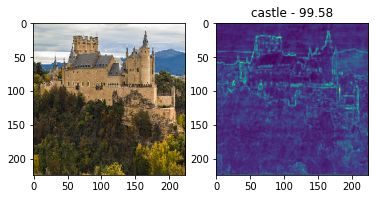

In [43]:
def XAI_plot(image_path, XAI ):
    image = load_img(image_path, target_size=(224, 224))
    image_array = img_to_array(image)
    XAI_img1 = XAI.run(np.expand_dims(image_array, axis=0))

    y = XAI.model.predict(np.expand_dims(image_array, axis=0))
    label = decode_predictions(y)
    label = label[0][0]

    plt.subplot(1, 2, 1)
    plt.imshow(image)

    plt.subplot(1, 2, 2)
    plt.imshow(image_array)
    plt.title(f"{label[1]} - {round(label[2]*100, 2)}")

    plt.imshow(XAI_img1)

XAI_plot('Castle.jpg', XAI=Xai_model)

# Implimentation of Bespoke Model

Change step 3 and emphasis for lowere layers: 
1.   Instead of multiply with Previous averaged map use weighted average
2.   use uneual weighted average for lower layers in the network



In [35]:
class VisualBackProp2():

    def __init__(self, model, alpha, emphasis):
        '''
        model:keras.engine.functional.Functional -> model for inference 
        '''
        self.model = model

        #layers whose ouput needs to be averaged and perform inverse opperation
        self.layers = [ layer for layer in model.layers if 'conv' in layer.name or 'pool' in layer.name]

        #averaged maps in the forward direction
        self.averaged_maps = []

        #image used to propogate in forward direction
        self.image = []

        #alpha for emphasis on low level detail
        self.alpha = alpha
        self.emphasis = emphasis
        self.beta = 1- self.alpha


    def get_avg_image(self, feature_maps):
        '''
        Average feature maps of convolutional or pooling layers along the depth
        Dimenssions : (Batch, Width, Hight, Depth)
        Args:
            feature_maps : feature maps to be averaged
        Returns:
            Tensor of Class probality for each class
        '''
        return tf.reduce_mean(feature_maps, axis=-1)

    def run(self, image):
        '''
        Run Xai model on an Image
        Dimenssions : (Batch, Width, Hight, Channels)

        Args:
            image : numpy array
        Returns:
            image : Numpy array for the VisualBackProp model
        '''
        result = self.forward(image)
        return self.backword()

    @staticmethod
    def rescale(x):
        """
        Rescales relevance scores of a batch of relevance maps between 0 and 1
        Args:
            x: RGB or grayscale relevance maps with dimensions (N, W, H, C) or (N, W, H), respectively.
        Returns:
            Rescaled relevance maps of same dimensions as input
        """
        x_min = np.min(x, axis=(0, 1), keepdims=True)
        x_max = np.max(x, axis=(0, 1), keepdims=True)
        #tf.cast(x, tf.float32)
        return (x - x_min) / (x_max - x_min)

    def forward(self, image):
        '''
        Forward pass on image input
        Args:
            Image :  image of dimension (Batch, Width, Hight, Channels)
        Returns:
            Tensor of Class probality for each class
        '''
        self.image = image
        self.averaged_maps = []
        image = preprocess_input(image)
        for layer in self.model.layers:

            image = layer(image)

            if layer in self.layers:
                self.averaged_maps.append(self.get_avg_image(image[0]))

        return image

    def backword(self):
        '''
        1.   We will use the feature maps obtained averaged during forward pass perform deconvolutional
        or unpooling.
        2.  We will use weighted avg for the scaled or deconvoluted maps and preceding averaged maps
        3.  We will continue till the input layer
        
        Returns:
            image : Numpy array for the VisualBackProp model
        '''
        reverse = self.averaged_maps[::-1]

        #alpha is the strenght of model's inferance to details in final output
        alpha = 0.95
        beta = 1-alpha

        for image in range(len(reverse)-1):

            dap = image<int(len(reverse)*self.emphasis)

            if reverse[image].shape != reverse[image+1].shape:
                input_x =  tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="nearest")(np.expand_dims(reverse[image], axis=[0, -1]))

                input_x = self.rescale(input_x)
                reverse[image+1] = self.rescale(reverse[image+1])
                
                if dap == False:
                    reverse[image+1] =tf.add(tf.squeeze( input_x, axis=[0, -1]),  reverse[image+1])/2
                
                else:
                    reverse[image+1] =tf.add(tf.squeeze( input_x, axis=[0, -1])*self.alpha,  reverse[image+1]*self.beta)

                reverse[image+1] = self.rescale(reverse[image+1])

            else:
                curr_layer = Xai_model.layers[len(Xai_model.layers)-1-image]
                input_x = tf.keras.layers.Conv2DTranspose(curr_layer.weights[0].shape[-1], curr_layer.input.shape[1:-1].as_list(), strides=(1, 1), padding="same")(np.expand_dims(reverse[image], axis=[0, -1]))
                input_x = tf.reduce_mean(input_x[0], axis=-1)



                if dap == False:
                    input_x = self.rescale(input_x)
                    reverse[image+1] = self.rescale(reverse[image+1])
                    reverse[image+1] = tf.add(input_x, reverse[image+1])/2

                else :
                    reverse[image+1] = tf.add(input_x*self.alpha, reverse[image+1]*self.beta)
                
        reverse[-1] = self.rescale(reverse[-1])
        
        return reverse[-1]

In [39]:
Xai_model2 = VisualBackProp2(model, 0.95, 0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


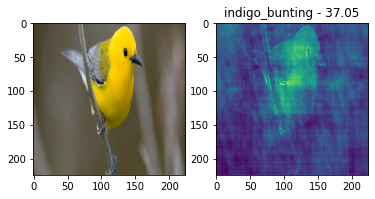

In [40]:
XAI_plot('bird.jpg', XAI=Xai_model2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


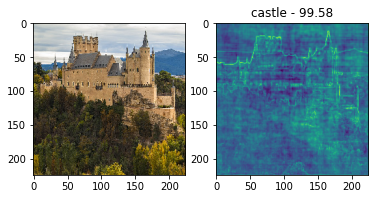

In [41]:
XAI_plot('Castle.jpg', XAI=Xai_model2)